In [163]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from cmath import isnan
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')

# matplotlibの設定
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

# gpuが使用される場合の設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [164]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity # サイクルバッファ
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [165]:
def conv2d_size_out(size, kernel_size, stride):
    return (size - (kernel_size - 1) - 1) // stride + 1

def convtran2d_size_out(size, kernel_size, stride, output_padding=0):
    return (size - 1) * stride + (kernel_size - 1) + output_padding + 1

In [166]:
def weight_init(m):
    """Custom weight init for Conv2D and Linear layers."""
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        m.bias.data.fill_(0.0)
    elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        # delta-orthogonal init from https://arxiv.org/pdf/1806.05393.pdf
        assert m.weight.size(2) == m.weight.size(3)
        m.weight.data.fill_(0.0)
        m.bias.data.fill_(0.0)
        mid = m.weight.size(2) // 2
        gain = nn.init.calculate_gain('relu')
        nn.init.orthogonal_(m.weight.data[:, :, mid, mid], gain)

def tie_weights(src, trg):
    assert type(src) == type(trg)
    trg.weight = src.weight
    trg.bias = src.bias


In [167]:
# obs -> featureにエンコード (SACでfeatureをstateとして用いる)
class Encoder(nn.Module):
    def __init__(self, obs_shape, feature_dim, num_layers=2, num_filters=32, lr=0.001):
        super().__init__()
        
        assert len(obs_shape) == 3 # obs_shape : CHW

        self.feature_dim = feature_dim
        self.num_layers = num_layers
        self.num_filters = num_filters
        self.kernel_size = 3
        self.stride = 2

        self.convs = nn.ModuleList([nn.Conv2d(obs_shape[0], self.num_filters, self.kernel_size, stride=self.stride)])
        for i in range(num_layers - 1):
            self.convs.append(nn.Conv2d(self.num_filters, self.num_filters, self.kernel_size, stride=self.stride))

        h = obs_shape[1]
        w = obs_shape[2]
        convh = conv2d_size_out(h, self.kernel_size, self.stride)
        convw = conv2d_size_out(w, self.kernel_size, self.stride)
        for i in range(num_layers - 1):
            convh = conv2d_size_out(convh, self.kernel_size, self.stride)
            convw = conv2d_size_out(convw, self.kernel_size, self.stride)
        self.linear_input_size = convw * convh * self.num_filters
        self.fc = nn.Linear(self.linear_input_size, self.feature_dim)
        self.ln = nn.LayerNorm(self.feature_dim)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    
    def forward(self, obs, detach=False):
        conv = F.relu(self.convs[0](obs))
        for i in range(1, self.num_layers):
            conv = F.relu(self.convs[i](conv))

        h = conv.view(conv.size(0), -1) # CHWを行ベクトルに変換
        if detach:
            h.detach()

        h = self.fc(h)
        feature = torch.tanh(self.ln(h))

        return feature

    def tie_conv_weights_from(self, source):
        tie_weights(src=source.fc, trg=self.fc)
        for i in range(self.num_layers):
            tie_weights(src=source.convs[i], trg=self.convs[i])

In [168]:
class Decoder(nn.Module):
    def __init__(self, obs_shape, feature_dim, num_layers=2, num_filters=32, latent_lambda=0.0, lr=0.001):
        super().__init__()

        self.feature_dim = feature_dim
        self.num_layers = num_layers
        self.num_filters = num_filters
        self.kernel_size = 3
        self.stride = 2

        h = obs_shape[1]
        w = obs_shape[2]
        for i in range(num_layers - 1):
            h = conv2d_size_out(h, self.kernel_size, self.stride)
            w = conv2d_size_out(w, self.kernel_size, self.stride)
        self.convh = conv2d_size_out(h, self.kernel_size, self.stride)
        self.convw = conv2d_size_out(w, self.kernel_size, self.stride)
        
        linear_input_size = self.convw * self.convh * self.num_filters
        self.fc = nn.Linear(self.feature_dim, linear_input_size)

        self.deconvs = nn.ModuleList()

        for i in range(self.num_layers - 1):
            self.deconvs.append(nn.ConvTranspose2d(self.num_filters, self.num_filters, self.kernel_size, stride=self.stride))
        self.deconvs.append(nn.ConvTranspose2d(num_filters, obs_shape[0], self.kernel_size, stride=self.stride, output_padding=1))

        self.latent_lambda = latent_lambda
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=self.latent_lambda)
        
    def forward(self, h):
        h = F.relu(self.fc(h))
        deconv = h.view(-1, self.num_filters, self.convh, self.convw)
        for i in range(0, self.num_layers - 1):
            deconv = F.relu(self.deconvs[i](deconv))
        obs = torch.sigmoid(self.deconvs[-1](deconv))  # 0-1に規格化. clipだと微分不可で進まない

        return obs

In [169]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, obs_shape, num_layers, num_filters, lr=0.003):  # obs_shape: (B, B, C, H, W)
        super(PolicyNetwork, self).__init__()

        self.encoder = Encoder(obs_shape[slice(2, 5)], state_dim, num_layers, num_filters)

        self.linear1 = nn.Linear(state_dim * obs_shape[1], 64) # 3つの連続した画像を入力（速度・加速度）
        self.linear2 = nn.Linear(64, 64)
        self.pi_mean = nn.Linear(64, action_dim)
        self.pi_stddev = nn.Linear(64, action_dim)

        self.apply(weight_init)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, obs_batch, detach=False):
        s = []
        for obs in obs_batch:
            s.append(self.encoder(obs, detach).reshape(1, -1)) # (1, state_dim)
        x = torch.cat(s)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mean = self.pi_mean(x)
        log_stddev = self.pi_stddev(x)

        stddev = torch.exp(log_stddev)

        return mean, stddev

In [170]:
class DualQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, obs_shape, num_layers, num_filters, lr=0.003): # obs_shape: (B, B, C, H, W)
        super(DualQNetwork, self).__init__()

        self.encoder = Encoder(obs_shape[slice(2, 5)], state_dim, num_layers, num_filters)

        # QNetwork 3
        self.linear1 = nn.Linear(state_dim * obs_shape[1] + action_dim, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 64)
        self.q1 = nn.Linear(64, 1)

        # QNetwork 2
        self.linear4 = nn.Linear(state_dim * obs_shape[1] + action_dim, 64)
        self.linear5 = nn.Linear(64, 64)
        self.linear6 = nn.Linear(64, 64)
        self.q2 = nn.Linear(64, 1)

        self.apply(weight_init)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, obs_batch, action, detach=False):
        s = []
        for obs in obs_batch:
            s.append(self.encoder(obs, detach).reshape(1, -1))  # (1, state_dim)
        state = torch.cat(s)
        x = torch.cat([state, action], 1)  # combination s and a
        
        # # QNetwork 1
        x1 = F.relu(self.linear1(x))
        x1 = F.relu(self.linear2(x1))
        x1 = F.relu(self.linear3(x1))
        q_value1 = self.q1(x1)

        # QNetwork 2
        x2 = F.relu(self.linear4(x))
        x2 = F.relu(self.linear5(x2))
        x2 = F.relu(self.linear6(x2))
        q_value2 = self.q2(x2)

        return q_value1, q_value2


In [171]:
def preprocess_obs(obs, bits=5):
    """Preprocessing image, see https://arxiv.org/abs/1807.03039."""
    bins = 2**bits
    assert obs.dtype == torch.float32
    if bits < 8:
        obs = torch.floor(obs / 2**(8 - bits))
    obs = obs / bins
    obs = obs + torch.rand_like(obs) / bins
    return obs

In [172]:
class SAC():
    def __init__(self, state_dim, action_space, obs_shape, num_layers, num_filters, decoder_latent_lambda,
                 buffer_size, gamma, soft_target_tau, encoder_soft_target_tau, target_entropy, policy_lr, q_lr, alpha_lr):
        super(SAC, self).__init__()

        self.state_dim = state_dim
        self.action_dim = action_space.shape[0]

        # Envアクション用にスケールする
        self.action_center = torch.FloatTensor((action_space.high + action_space.low) / 2).to(device)
        self.action_scale = torch.FloatTensor(action_space.high - self.action_center.cpu().detach().numpy()).to(device)

        # Neural Networks
        self.policy_net = PolicyNetwork(self.state_dim, self.action_dim, obs_shape, num_layers, num_filters, policy_lr).to(device)
        
        self.q_net = DualQNetwork(self.state_dim, self.action_dim, obs_shape, num_layers, num_filters, q_lr).to(device)
        self.target_q_net = DualQNetwork(self.state_dim, self.action_dim, obs_shape, num_layers, num_filters, q_lr).to(device)

        # for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
        #     target_param.data.copy_(param.data)
        self.target_q_net.load_state_dict(self.q_net.state_dict()) # target_q_netとq_netを同期

        self.policy_net.encoder.tie_conv_weights_from(self.q_net.encoder)
        
        self.decoder = Decoder(obs_shape[slice(2, 5)], state_dim, num_layers, num_filters, decoder_latent_lambda).to(device)
        self.decoder.apply(weight_init)

        # Experiences
        self.replay_memory = ReplayMemory(buffer_size)

        self.target_entropy = -self.action_dim
        self.log_alpha = torch.zeros(1, requires_grad=True)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=alpha_lr)

        # Hyper Parameters
        self.gamma = gamma
        self.soft_target_tau = soft_target_tau
        self.encoder_soft_target_tau = encoder_soft_target_tau
        self.target_entropy = target_entropy

        self.count = 0

    def sample_action(self, state):
        mean, stddev = self.policy_net(state)

        # Reparameterization
        normal_random = torch.normal(0, 1, size=mean.shape).to(device)
        action_org = mean + stddev * normal_random

        # Squashed Gaussian Policy
        action = torch.tanh(action_org)

        return action.to(device), mean.to(device), stddev.to(device), action_org.to(device)

    def sample_action_for_env(self, state):
        action, _, _, _ = self.sample_action(state)
        env_action = action * self.action_scale + self.action_center

        return env_action.cpu().detach().numpy()[0], action.cpu().detach().numpy()[0]

    # 正規分布でのactionの対数確率密度関数logμ(a|s)
    def compute_logpi(self, mean, stddev, action):
        a1 = -0.5 * np.log(2*np.pi)
        a2 = -torch.log(stddev)
        a3 = -0.5 * (((action - mean) / stddev) ** 2)
        return (a1 + a2 + a3).to(device)

    # tanhで変換されたactionのlogπ(a|s)をaction_orgを使って計算
    def compute_logpi_sgp(self, mean, stddev, action_org):
        logmu = self.compute_logpi(mean, stddev, action_org)
        tmp = 1 - torch.tanh(action_org) ** 2
        tmp = torch.clip(tmp, 1e-10, 1.0)  # log(0)回避
        logpi = logmu - torch.sum(torch.log(tmp), 1, keepdim=True)
        return logpi.to(device)


    def update(self, batch_size, q_net_sync=False):
        # 経験をバッチでサンプリング
        transitions = self.replay_memory.sample(batch_size)
        batch = Transition(*zip(*transitions))

        obs_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        n_obs_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)

        alpha = torch.exp(self.log_alpha)
        
        # Q(s,a)の推定値を計算し, Q値の損失関数を計算
        with torch.no_grad():
            n_action, n_mean, n_stddev, n_action_org = self.sample_action(n_obs_batch)
            
            n_logpi = self.compute_logpi_sgp(n_mean, n_stddev, n_action_org)
            n_q1, n_q2 = self.target_q_net(n_obs_batch, n_action)
          
            q_est = reward_batch + (1 - done_batch) * self.gamma * torch.minimum(n_q1, n_q2) - (alpha * n_logpi)
        q1, q2 = self.q_net(obs_batch, action_batch.detach())
        q1_loss = F.mse_loss(q1, q_est.float())
        q2_loss = F.mse_loss(q2, q_est.float())
        q_loss = q1_loss + q2_loss
        
        # q_lossからQNetworkを学習
        self.q_net.optimizer.zero_grad()
        q_loss.backward()
        self.q_net.optimizer.step()

        # 方策の損失関数を計算
        action, mean, stddev, action_org = self.sample_action(obs_batch) # 現在の方策π(θ)で選ばれるactionについて評価     
        logpi = self.compute_logpi_sgp(mean, stddev, action_org)
        q1, q2 = self.q_net(obs_batch, action)
        q_min = torch.minimum(q1, q2)
        policy_loss = -(q_min - alpha.detach() * logpi).mean()

        # policy_lossからPolicyNetworkを学習
        self.policy_net.optimizer.zero_grad()
        policy_loss.backward()
        self.policy_net.optimizer.step()

        # αの自動調整
        alpha_loss = (-alpha * (logpi + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        # Encoder/Decoderの学習
        target_obs = obs_batch[:, -1]
        h = self.q_net.encoder(target_obs)

        rec_obs = self.decoder(h)

        # if target_obs.dim() == 4:
        #     target_obs = preprocess_obs(target_obs)

        rec_loss = F.mse_loss(rec_obs, target_obs)

        # L2拘束
        latent_loss = (0.5 * h.pow(2).sum(1)).mean()

        encoder_loss = rec_loss + self.decoder.latent_lambda * latent_loss

        self.q_net.encoder.optimizer.zero_grad()
        self.decoder.optimizer.zero_grad()
        encoder_loss.backward()
        self.q_net.encoder.optimizer.step()
        self.decoder.optimizer.step()

        self.count += 1

        # ソフトターゲットで更新 (Q-NetとEncoder)
        for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.soft_target_tau) + param.data * self.soft_target_tau)
        
        for target_enc_param, enc_param in zip(self.target_q_net.encoder.parameters(), self.q_net.encoder.parameters()):
            target_enc_param.data.copy_(target_enc_param.data * (1.0 - self.encoder_soft_target_tau) + enc_param.data * self.encoder_soft_target_tau)

        # q_net_syncフラグが有効ならq_netを同期させる
        if q_net_sync:
            for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
                target_param.data.copy_(param.data)

            for target_enc_param, enc_param in zip(self.target_q_net.encoder.parameters(), self.q_net.encoder.parameters()):
                target_enc_param.data.copy_(enc_param.data)
        
        return policy_loss.cpu().detach().numpy(), q_loss.cpu().detach().numpy(), rec_loss.cpu().detach().numpy()

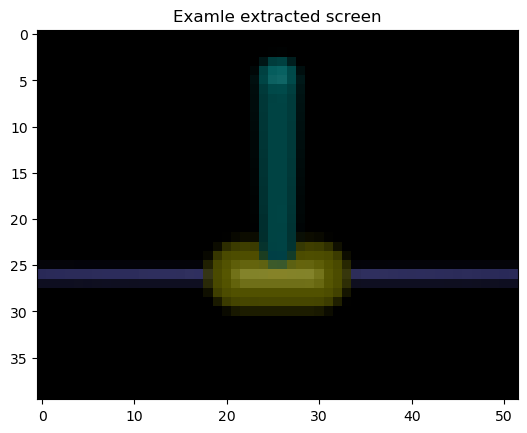

In [173]:
resize = T.Compose([T.ToPILImage(), T.Resize(40, T.InterpolationMode.BICUBIC), T.ToTensor()])


def get_screen():
    # PyTorch標準のCHWに変換
    screen = env.render().transpose(2, 0, 1)
    _, screen_height, screen_width = screen.shape

    # sliceでscreenをトリミング
    height_slice = slice(int(screen_height * 0.1), int(screen_height * 0.7))
    screen = screen[:, height_slice]
    width_slice = slice(int(screen_width * 0.11), int(screen_width * 0.89))
    screen = screen[:, :, width_slice]

    # float32に変換し0-1に正規化
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Tensorに変換
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)


# Example
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.title('Examle extracted screen')
plt.show()


In [174]:
# ハイパーパラメータ
buffer_size = 1000  # Experienceのキュー容量
warmup_size = 500  # 学習するかどうかのExperienceの最低限の容量
train_interval = 10  # 学習する制御周期間隔
batch_size = 32  # バッチサイズ
gamma = 0.9  # 割引率
soft_target_tau = 0.02  # Soft TargetでTargetに近づく割合
encoder_soft_target_tau = 0.05 # Qのτよりも大きい数値
hard_target_interval = 100  # Hard Targetで同期する間隔
lr = 0.001
target_entropy = -1 * env.action_space.shape[0]  # エントロピーαの目標値: -1xアクション数がいいらしい

state_dim = 50  # 画像から抽出される特徴量の次元
obs_shape = torch.stack([torch.cat([get_screen(), get_screen(), get_screen()])]).shape
num_layers = 2
num_filters = 32
decoder_latent_lambda = 0.0

sac = SAC(state_dim, env.action_space, obs_shape, num_layers, num_filters, decoder_latent_lambda, 
          buffer_size, gamma, soft_target_tau, encoder_soft_target_tau, target_entropy, lr, lr, lr)

step_count = 0
train_count = 0

# 記録用
history_rewards = []
history_metrics = []
history_metrics_y = []


# 学習ループ
for episode in range(5000):
    env.reset()
    
    obs = get_screen()
    prev_obs = get_screen()
    prev_prev_obs = get_screen()
    state = torch.stack([torch.cat([prev_prev_obs, prev_obs, obs])])
    done = False
    total_reward = 0
    
    step = 0

    metrics_list = []

    # １エピソード
    while not done:
        # アクションを決定
        env_action, action = sac.sample_action_for_env(state)
        if isnan(env_action[0]):
            print("action is NaN. 学習失敗.")
            break
        # print("state:", state, "action:", action)

        _, reward, terminated, truncated, _ = env.step(env_action)
        
        prev_prev_obs = prev_obs
        prev_obs = obs
        obs = get_screen()
        if not done:
            n_state = torch.stack([torch.cat([prev_prev_obs, prev_obs, obs])])
        else:
            n_state = None
        step += 1
        total_reward += reward
        done = terminated or truncated

        sac.replay_memory.push(
            state.clone().detach().to(device),
            torch.tensor(action, dtype=torch.float32).reshape(1, -1).to(device),
            n_state.clone().detach().to(device),
            torch.tensor(reward, dtype=torch.float32).reshape(1, -1).to(device),
            torch.tensor(done, dtype=torch.float32).reshape(1, -1).to(device))

        state = n_state

        # train_interval毎に, warmup貯まっていたら学習する
        if len(sac.replay_memory) >= warmup_size and step_count % train_interval == 0:
            q_net_sync = False
            if train_count % hard_target_interval == 0:
                q_net_sync = True
            # モデルの更新
            metrics = sac.update(
                batch_size,
                q_net_sync)
           
            train_count += 1
            metrics_list.append(metrics)
        step_count += 1

    # 報酬
    history_rewards.append(total_reward)

    # メトリクス
    if len(metrics_list) > 0:
        history_metrics.append(np.mean(metrics_list, axis=0))  # 平均を保存
        history_metrics_y.append(episode)

    #--- print
    interval = 5
    if episode % interval == 0:
        print("{} (min,ave,max)reward {:.1f} {:.1f} {:.1f}, alpha={:.3f}".format(
            episode,
            min(history_rewards[-interval:]),
            np.mean(history_rewards[-interval:]),
            max(history_rewards[-interval:]),
            torch.exp(sac.log_alpha).cpu().detach().numpy()[0],
        ))

env.close()

0 (min,ave,max)reward 9.0 9.0 9.0, alpha=1.000
5 (min,ave,max)reward 3.0 6.4 11.0, alpha=1.000
10 (min,ave,max)reward 3.0 5.2 10.0, alpha=1.000
15 (min,ave,max)reward 3.0 4.6 7.0, alpha=1.000
20 (min,ave,max)reward 3.0 7.2 13.0, alpha=1.000
25 (min,ave,max)reward 3.0 5.4 8.0, alpha=1.000
30 (min,ave,max)reward 3.0 4.6 8.0, alpha=1.000
35 (min,ave,max)reward 3.0 4.4 6.0, alpha=1.000
40 (min,ave,max)reward 3.0 5.8 8.0, alpha=1.000
45 (min,ave,max)reward 3.0 3.0 3.0, alpha=1.000
50 (min,ave,max)reward 3.0 5.0 9.0, alpha=1.000
55 (min,ave,max)reward 4.0 6.2 8.0, alpha=1.000
60 (min,ave,max)reward 3.0 3.4 4.0, alpha=1.000
65 (min,ave,max)reward 3.0 3.6 4.0, alpha=1.000
70 (min,ave,max)reward 3.0 8.4 16.0, alpha=1.000
75 (min,ave,max)reward 3.0 5.4 9.0, alpha=1.000
80 (min,ave,max)reward 3.0 4.2 7.0, alpha=1.000
85 (min,ave,max)reward 3.0 6.2 15.0, alpha=1.000
90 (min,ave,max)reward 3.0 5.2 7.0, alpha=1.000
95 (min,ave,max)reward 3.0 3.2 4.0, alpha=1.000
100 (min,ave,max)reward 3.0 5.8 10.0,

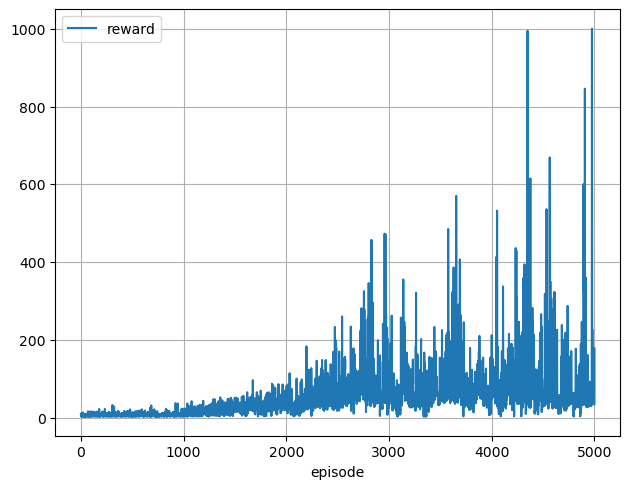

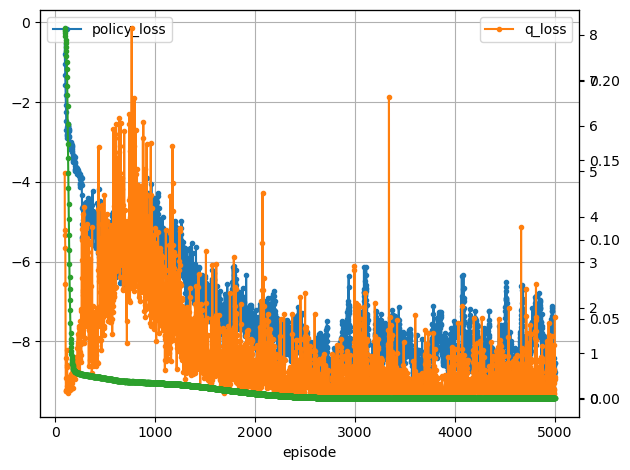

In [178]:
# プロット
plt.plot(history_rewards, label="reward")
plt.tight_layout()
plt.xlabel('episode')
plt.grid()
plt.legend()
plt.show()

fig, ax1 = plt.subplots()

ax1.set_xlabel('episode')
ax1.grid()
ax1.plot(history_metrics_y, [m[0] for m in history_metrics], color="C0", marker='.', label="policy_loss")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(history_metrics_y, [m[1] for m in history_metrics], color="C1", marker='.', label="q_loss")
ax2.legend(loc='upper right')


ax3 = ax1.twinx()
ax3.plot(history_metrics_y, [m[2] for m in history_metrics], color="C2", marker='.', label="rec_loss")
ax2.legend(loc='upper right')

fig.tight_layout()  # レイアウトの設定
# plt.savefig('cartpole2.png') # 画像の保存
plt.show()

In [204]:
# テスト
from IPython import display
from pyvirtualdisplay import Display
from matplotlib import animation

d = Display()
d.start()
img = []

for episode in range(1):
    env.reset()

    obs = get_screen()
    prev_obs = get_screen()
    prev_prev_obs = get_screen()
    state = torch.stack([torch.cat([prev_prev_obs, prev_obs, obs])])
    done = False
    total_reward = 0
    step = 0
    
    img.append(env.render())

    # １エピソード
    while not done:
        env_action, action = sac.sample_action_for_env(state)
        _, reward, terminated, truncated, _ = env.step(env_action)

        prev_prev_obs = prev_obs
        prev_obs = obs
        obs = get_screen()
        if not done:
            state = torch.stack([torch.cat([prev_prev_obs, prev_obs, obs])])
        else:
            state = None
        step += 1
        total_reward += reward
        done = terminated or truncated

        # 動画化に毎step描画を追加
        display.clear_output(wait=True)
        img.append(env.render())

        if done:
            break

    print("{} step, reward: {}".format(step, total_reward))
env.close()


93 step, reward: 93.0


In [205]:
# 動画を表示

dpi = 72
interval = 50  # ms

plt.figure(figsize=(img[0].shape[1]/dpi, img[0].shape[0]/dpi), dpi=dpi)
patch = plt.imshow(img[0])
plt.axis = ('off')
def animate(i): return patch.set_data(img[i])


ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(img), interval=interval)
display.display(display.HTML(ani.to_jshtml()))
plt.close()